In [1]:
!pip install --upgrade pip
!pip install python-decouple
!pip install geoalchemy2
!pip install shapely
!pip install scipy
!pip install category-encoders

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (19.1.1)
     |████████████████████████████████| 92kB 2.1MB/s eta 0:00:011
     |████████████████████████████████| 6.6MB 5.0MB/s eta 0:00:01
     |████████████████████████████████| 286kB 56.1MB/s eta 0:00:01
  Found existing installation: scikit-learn 0.19.1
    Uninstalling scikit-learn-0.19.1:
      Successfully uninstalled scikit-learn-0.19.1


In [2]:
from sqlalchemy import create_engine, func, text
from sqlalchemy.orm import sessionmaker
from decouple import config
from shapely import wkb, wkt
from shapely.geometry import Point
from geoalchemy2.shape import to_shape 

import pandas as pd
import numpy as np
import random
import json
from datetime import datetime, timedelta
import re
from matplotlib import pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder

In [3]:
"""Contains models for DB."""

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, BigInteger, Integer, String, DateTime, ForeignKey, Float
from sqlalchemy.orm import relationship
from geoalchemy2 import Geometry


BASE = declarative_base()


class City(BASE):
    """City model for DB. Has information of cities."""
    __tablename__ = 'city'
    id            = Column(BigInteger, primary_key=True)
    city          = Column(String, unique=False, nullable=False)
    state         = Column(String, unique=False, nullable=True)
    country       = Column(String, unique=False, nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    blocks        = relationship("Blocks", back_populates="city")
    zipcodes      = relationship("ZipcodeGeom", back_populates="city")
    incidents     = relationship("Incident", back_populates="city")


class Blocks(BASE):
    """Block model for DB. Has information of city blocks for a related city
        id."""
    __tablename__ = 'block'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    population    = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="blocks")
    incidents     = relationship("Incident", back_populates="block")

class ZipcodeGeom(BASE):
    """Zipcode geometry model for DB. Has information of zipcodes and related
        city id."""
    __tablename__ = 'zipcodegeom'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    zipcode       = Column(String, nullable=False, unique=True)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    city          = relationship("City", back_populates="zipcodes")

class Incident(BASE):
    """Incident model for DB. Has information of a specific crime, including
        where it took place, when it took place, and the type of crime that
        occurred."""
    __tablename__ = 'incident'
    id            = Column(BigInteger, primary_key=True)
    crimetypeid   = Column(BigInteger, ForeignKey('crimetype.id'), nullable=False)
    locdescid     = Column(BigInteger, ForeignKey('locdesctype.id'), nullable=False)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    blockid       = Column(BigInteger, ForeignKey('block.id'), nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    datetime      = Column(DateTime, nullable=False)
    hour          = Column(Integer, nullable=False)
    dow           = Column(Integer, nullable=False)
    month         = Column(Integer, nullable=False)
    year          = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="incidents")
    block         = relationship("Blocks", back_populates="incidents")
    crimetype     = relationship("CrimeType", back_populates="incidents")
    locationdesc  = relationship("LocationDescriptionType", back_populates="incidents")

class CrimeType(BASE):
    """CrimeType model for DB. Has information of the types of crime, including
        a general description and the numerical severity of the crime."""
    __tablename__ = 'crimetype'
    id            = Column(BigInteger, primary_key=True)
    category      = Column(String, unique=True, nullable=False)
    severity      = Column(Integer, nullable=False)
    incidents     = relationship("Incident", back_populates="crimetype")


class LocationDescriptionType(BASE):
    """Location description model for DB. Has information on the type of
        location that the crime took place."""
    __tablename__ = 'locdesctype'
    id            = Column(BigInteger, primary_key=True)
    key1          = Column(String, nullable=False)
    key2          = Column(String, nullable=False)
    key3          = Column(String, nullable=False)
    incidents     = relationship("Incident", back_populates="locationdesc")

In [4]:
class GetDataFull(object):
    def go(self, SESSION, start_year, end_year):
        SQL_QUERY = \
            f'''
            SELECT incident.blockid,
                    incident.datetime,
                    incident.year, 
                    incident.month, 
                    incident.dow, 
                    incident.hour,
                    SUM(crimetype.severity)/AVG(block.population) AS severity
            FROM incident
            INNER JOIN block ON incident.blockid = block.id INNER JOIN crimetype ON incident.crimetypeid = crimetype.id AND block.population > 0
                AND block.population > 0
                AND severity > 0
                AND incident.cityid = 1
                AND incident.year >= {start_year}
                AND incident.year <= {end_year}
            GROUP BY
                incident.blockid,
                incident.datetime,
                incident.year,
                incident.month,
                incident.dow,
                incident.hour
            '''
        return SESSION.execute(text(SQL_QUERY)).fetchall()

In [5]:
def days_in_month(year, month):
    p = pd.Period(f'{year}-{month}-1')
    return p.days_in_month

def day_of_week(dt):
    return dt.weekday()

def create_arrays(blockids, start_year, end_year):
    idx = 0
    X_blockid, X_datetime, X_year, X_month, X_day, X_dow, X_hour, X_risk = [], [], [], [], [], [], [], []
    for blockid in blockids:
        for year in range(start_year, end_year + 1):
            for month in range(1, 12 + 1):      # month range is 1-12
                for day in range(1, days_in_month(year, month) + 1):
                    for hour in range(24):      # hour range is 0-23
                        X_blockid.append(blockid)
                        X_datetime.append(datetime(year, month, day, hour, 0, 0, 0))
                        X_year.append(year)
                        X_month.append(month)
                        X_day.append(day)
                        X_dow.append(day_of_week(datetime(year, month, day)))
                        X_hour.append(hour)
                        X_risk.append(0.0)
                        idx += 1
    
    X = pd.DataFrame({'blockid':  X_blockid,
                      'datetime': X_datetime,
                      'year':     X_year,
                      'month':    X_month,
                      'day':      X_day,
                      'dow':      X_dow,
                      'hour':     X_hour,
                      'risk':     X_risk})

    return X

In [6]:
def process_data_full(data, start_year, end_year):

    def remove_outliers_from_risk(risk):
        std = np.std(risk)
        risk = np.where(risk < 20*std, 
                     risk, 
                     [0.]*len(risk)).reshape(risk.shape)

        return risk
    
    def binary_encode_blockids(X):
        encoded_blockids = pd.DataFrame(BinaryEncoder(cols=['blockid']) \
                                        .fit_transform(X))
        
        X = pd.concat([X, encoded_blockids], axis=1,
                      names=['blockid' + str(i) for i in range(1, 801 +1)])
        X = X.drop(columns=['blockid'])
        return X
    
    NUM_BLOCKIDS = 801
    
    delta_years = end_year - start_year + 1
    
    X = create_arrays(range(1, NUM_BLOCKIDS + 1), start_year, end_year)
    X = X.drop(columns=['year', 'month', 'day', 'dow', 'hour'], axis=1)

    # records is the list of rows we get from the query with this order:
    #   blockid, datetime, year, month, dow, hour, risk
    #   month is from 1 - 12
    
    X1 = []
    for r in data:
        X1.append((r[0], r[1], r[6]))

    X1 = pd.DataFrame(data=X1,
                      columns=['blockid', 'datetime', 'risk2'])
    X1['risk2'] = remove_outliers_from_risk(X1['risk2'].astype(float))
    
    return X1, X

#     X = pd.merge(X, X1, 
#                  how='left',
#                  left_on=['blockid', 'datetime'],
#                  right_on=['blockid', 'datetime']
#                 )
#     X['all_risk'] = X.risk.astype(float) + X.risk2.astype(float)
#     df = X.drop(columns=['risk', 'risk2']) \
#          .rename(mapper={'all_risk': 'risk'}, axis=1)
    
#     y = df['risk'].copy()
#     df = df.drop(columns=['risk'])
    
#     y = remove_outliers_from_risk(y)
#     df = binary_encode_blockids(df)
#     df['risk'] = y
#     df1 = df.iloc[:, :-2]
#     df2 = df.iloc[:, -1]
#     df = pd.concat([df1, df2], axis=1)
    
#     return df

In [7]:
from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""

    DB_URI  = config('DB_URI')
    ENGINE  = create_engine(DB_URI)
    Session = sessionmaker(bind=ENGINE)
    SESSION = Session()
    
    try:
        yield SESSION
        SESSION.commit()
    except:
        SESSION.rollback()
        raise
    finally:
        SESSION.close()


def ready_data_full(training_start_year, training_end_year,
                    testing_start_year, testing_end_year):
    with session_scope() as session:
        training_data = GetDataFull().go(session,
                                         training_start_year,
                                         training_end_year)
        testing_data = GetDataFull().go(session,
                                         testing_start_year,
                                         testing_end_year)
        train, train_generated = process_data_full(training_data,
                                                 training_start_year, 
                                                 training_end_year)
        test, test_generated = process_data_full(testing_data,
                                               testing_start_year, 
                                               testing_end_year)

    return train, test, train_generated, test_generated

In [17]:
%%time
train, test, train_generated, test_generated = ready_data_full(2015, 2017, 2016, 2018)

CPU times: user 2min 11s, sys: 12.5 s, total: 2min 23s
Wall time: 2min 55s


In [18]:
train.shape, test.shape, train_generated.shape, test_generated.shape

((761999, 3), (765976, 3), (21069504, 3), (21069504, 3))

In [19]:
train.head()

,blockid,datetime,risk2
0,1,2015-01-01 00:00:00,0.000605
1,1,2015-01-01 02:00:00,0.000908
2,1,2015-01-02 10:30:00,0.000605
3,1,2015-01-03 09:40:00,0.000303
4,1,2015-01-03 22:30:00,0.001816


In [55]:
train2 = train.set_index('datetime')

In [56]:
group = train2.groupby('blockid')
# for k in group.groups.keys():
#     g = group.get_group(k)
g = group.get_group(1)
g['risk2'].reset_index(drop=True)
merged = pd.merge(train_generated, g.reset_index(), 
                 how='left',
                 left_on=['blockid', 'datetime'],
                 right_on=['blockid', 'datetime']
                )
merged.head()

,blockid,datetime,risk,risk2
0,1,2015-01-01 00:00:00,0.0,0.000605
1,1,2015-01-01 01:00:00,0.0,NaN
2,1,2015-01-01 02:00:00,0.0,0.000908
3,1,2015-01-01 03:00:00,0.0,NaN
4,1,2015-01-01 04:00:00,0.0,NaN


In [57]:
merged = merged.fillna(value=0)
merged['all_risk'] = merged['risk'] + merged['risk2']
merged = merged.drop(columns=['blockid', 'risk', 'risk2']) \
            .rename(mapper={'all_risk': 'risk'}, axis=1) \
            .set_index('datetime')
print('merged.shape:', merged.shape)
merged.head()

merged.shape: (21069504, 1)


,risk
datetime,
2015-01-01 00:00:00,0.000605
2015-01-01 01:00:00,0.000000
2015-01-01 02:00:00,0.000908
2015-01-01 03:00:00,0.000000
2015-01-01 04:00:00,0.000000


## Search for the best model

In [44]:
!pip install statsmodels

import itertools
import warnings
from scipy.stats import norm
import statsmodels.api as sm

In [60]:
def find_good_model(param_start, param_end, y):

    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(param_start, param_end)

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, d and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    print('Examples of parameter combinations for Seasonal ARIMA...')
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
    
    # warnings.filterwarnings("ignore") # specify to ignore warning messages
    lowest_aic = None
    lowest_param = None
    lowest_param_seasonal = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()

                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                if lowest_aic is None:
                    lowest_aic = results.aic
                    lowest_param = param
                    lowest_param_seasonal = param_seasonal
                elif lowest_aic > results.aic:  # The model with the lowest AIC is preferred over other models
                    lowest_aic = results.aic
                    lowest_param = param
                    lowest_param_seasonal = param_seasonal
            except:
                continue

    if lowest_aic is None:
        raise ValueError('Lowest AIC cannot be None')
    print('Lowest AIC:', lowest_aic)
    print('Lowest AIC param:', lowest_aic_param)
    print('Lowest AIC param_seasonal:', lowest_aic_param_seasonal)
        
    mod = sm.tsa.statespace.SARIMAX(y,
                                    order=lowest_param,
                                    seasonal_order=lowest_param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()

    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (-2, -2, -1) x (-2, -2, -1, 12)
SARIMAX: (-2, -2, -1) x (-2, -2, 0, 12)
SARIMAX: (-2, -2, 0) x (-2, -2, 1, 12)
SARIMAX: (-2, -2, 0) x (-2, -1, -2, 12)


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(-2, 0, -2, 12)12 - AIC:-46283.85719916151


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(-2, 0, -1, 12)12 - AIC:-46283.85719916151


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(-2, 0, 0, 12)12 - AIC:-46283.85719916151


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(-2, 0, 1, 12)12 - AIC:-46156.325045770165
ARIMA(0, 0, 0)x(-2, 1, -2, 12)12 - AIC:-44083.81990570843
ARIMA(0, 0, 0)x(-2, 1, -1, 12)12 - AIC:-44083.81990570843
ARIMA(0, 0, 0)x(-2, 1, 0, 12)12 - AIC:-44083.81990570843


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(-2, 1, 1, 12)12 - AIC:-45561.03501773022


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(-1, 0, -2, 12)12 - AIC:-46283.85719916151


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(-1, 0, -1, 12)12 - AIC:-46283.85719916151


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(-1, 0, 0, 12)12 - AIC:-46283.85719916151


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(-1, 0, 1, 12)12 - AIC:-46156.325045770165
ARIMA(0, 0, 0)x(-1, 1, -2, 12)12 - AIC:-44083.81990570843
ARIMA(0, 0, 0)x(-1, 1, -1, 12)12 - AIC:-44083.81990570843
ARIMA(0, 0, 0)x(-1, 1, 0, 12)12 - AIC:-44083.81990570843


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(-1, 1, 1, 12)12 - AIC:-45561.03501773022


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, -2, 12)12 - AIC:-46283.85719916151


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, -1, 12)12 - AIC:-46283.85719916151


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-46283.85719916151


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-46156.325045770165
ARIMA(0, 0, 0)x(0, 1, -2, 12)12 - AIC:-44083.81990570843
ARIMA(0, 0, 0)x(0, 1, -1, 12)12 - AIC:-44083.81990570843
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-44083.81990570843


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-45561.03501773022


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, -2, 12)12 - AIC:-46173.06295367532


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, -1, 12)12 - AIC:-46173.06295367532


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-46173.06295367532


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-46126.61868428918


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, -2, 12)12 - AIC:-44783.685255466815


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, -1, 12)12 - AIC:-44783.685255466815


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-44783.685255466815
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-45589.21688138024


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(-2, 0, -2, 12)12 - AIC:-46264.906336562264


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(-2, 0, -1, 12)12 - AIC:-46264.906336562264


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(-2, 0, 0, 12)12 - AIC:-46264.906336562264


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(-2, 0, 1, 12)12 - AIC:-46138.16185844394


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(-2, 1, -2, 12)12 - AIC:-44065.88117117555


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(-2, 1, -1, 12)12 - AIC:-44065.88117117555


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(-2, 1, 0, 12)12 - AIC:-44065.88117117555
ARIMA(0, 0, 1)x(-2, 1, 1, 12)12 - AIC:-45519.42600495501


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(-1, 0, -2, 12)12 - AIC:-46264.906336562264


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(-1, 0, -1, 12)12 - AIC:-46264.906336562264


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(-1, 0, 0, 12)12 - AIC:-46264.906336562264


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(-1, 0, 1, 12)12 - AIC:-46138.16185844394


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(-1, 1, -2, 12)12 - AIC:-44065.88117117555


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(-1, 1, -1, 12)12 - AIC:-44065.88117117555


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(-1, 1, 0, 12)12 - AIC:-44065.88117117555
ARIMA(0, 0, 1)x(-1, 1, 1, 12)12 - AIC:-45519.42600495501


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, -2, 12)12 - AIC:-46264.906336562264


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, -1, 12)12 - AIC:-46264.906336562264


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-46264.906336562264


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-46138.16185844394


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 1, -2, 12)12 - AIC:-44065.88117117555


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 1, -1, 12)12 - AIC:-44065.88117117555


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-44065.88117117555
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-45519.42600495501


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, -2, 12)12 - AIC:-46171.34597439485


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, -1, 12)12 - AIC:-46171.34597439485


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-46171.34597439485


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-46108.17957307823
ARIMA(0, 0, 1)x(1, 1, -2, 12)12 - AIC:-44781.87602948819
ARIMA(0, 0, 1)x(1, 1, -1, 12)12 - AIC:-44781.87602948819
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-44781.87602948819
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-45571.32670815998


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(-2, 0, -2, 12)12 - AIC:-44221.0682964415


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(-2, 0, -1, 12)12 - AIC:-44221.0682964415


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(-2, 0, 0, 12)12 - AIC:-44221.0682964415


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(-2, 0, 1, 12)12 - AIC:-44102.29100178169


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(-2, 1, -2, 12)12 - AIC:-41990.44139149939


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(-2, 1, -1, 12)12 - AIC:-41990.44139149939


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(-2, 1, 0, 12)12 - AIC:-41990.44139149939
ARIMA(0, 1, 0)x(-2, 1, 1, 12)12 - AIC:-43278.38788580895


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(-1, 0, -2, 12)12 - AIC:-44221.0682964415


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(-1, 0, -1, 12)12 - AIC:-44221.0682964415


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(-1, 0, 0, 12)12 - AIC:-44221.0682964415


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(-1, 0, 1, 12)12 - AIC:-44102.29100178169


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(-1, 1, -2, 12)12 - AIC:-41990.44139149939


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(-1, 1, -1, 12)12 - AIC:-41990.44139149939


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(-1, 1, 0, 12)12 - AIC:-41990.44139149939
ARIMA(0, 1, 0)x(-1, 1, 1, 12)12 - AIC:-43278.38788580895


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, -2, 12)12 - AIC:-44221.0682964415


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, -1, 12)12 - AIC:-44221.0682964415


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-44221.0682964415


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-44102.29100178169


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, -2, 12)12 - AIC:-41990.44139149939


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, -1, 12)12 - AIC:-41990.44139149939


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:-41990.44139149939
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-43278.38788580895


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, -2, 12)12 - AIC:-44118.24408824973


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, -1, 12)12 - AIC:-44118.24408824973


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-44118.24408824973
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-44100.348560504426
ARIMA(0, 1, 0)x(1, 1, -2, 12)12 - AIC:-42638.02393303432
ARIMA(0, 1, 0)x(1, 1, -1, 12)12 - AIC:-42638.02393303432
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-42638.02393303432
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-43056.013835035046


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(-2, 0, -2, 12)12 - AIC:-45942.63435926009


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(-2, 0, -1, 12)12 - AIC:-45942.63435926009


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(-2, 0, 0, 12)12 - AIC:-45942.63435926009


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(-2, 0, 1, 12)12 - AIC:-45772.8464697552


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(-2, 1, -2, 12)12 - AIC:-43654.383861159266


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(-2, 1, -1, 12)12 - AIC:-43654.383861159266


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(-2, 1, 0, 12)12 - AIC:-43654.383861159266


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(-2, 1, 1, 12)12 - AIC:-45082.61108508614


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(-1, 0, -2, 12)12 - AIC:-45942.63435926009


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(-1, 0, -1, 12)12 - AIC:-45942.63435926009


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(-1, 0, 0, 12)12 - AIC:-45942.63435926009


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(-1, 0, 1, 12)12 - AIC:-45772.8464697552


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(-1, 1, -2, 12)12 - AIC:-43654.383861159266


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(-1, 1, -1, 12)12 - AIC:-43654.383861159266


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(-1, 1, 0, 12)12 - AIC:-43654.383861159266


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(-1, 1, 1, 12)12 - AIC:-45082.61108508614


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 0, -2, 12)12 - AIC:-45942.63435926009


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 0, -1, 12)12 - AIC:-45942.63435926009


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-45942.63435926009


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-45772.8464697552


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, -2, 12)12 - AIC:-43654.383861159266


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, -1, 12)12 - AIC:-43654.383861159266


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-43654.383861159266


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-45082.61108508614
ARIMA(0, 1, 1)x(1, 0, -2, 12)12 - AIC:-45805.34775970482
ARIMA(0, 1, 1)x(1, 0, -1, 12)12 - AIC:-45805.34775970482
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-45805.34775970482
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(0, 1, 1)x(1, 1, -2, 12)12 - AIC:nan
ARIMA(0, 1, 1)x(1, 1, -1, 12)12 - AIC:nan
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:nan
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:-44743.452804422246


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(-2, 0, -2, 12)12 - AIC:-46282.187478323016


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(-2, 0, -1, 12)12 - AIC:-46282.187478323016


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(-2, 0, 0, 12)12 - AIC:-46282.187478323016


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(-2, 0, 1, 12)12 - AIC:-46154.66193409922


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(-2, 1, -2, 12)12 - AIC:-44081.841466535705


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(-2, 1, -1, 12)12 - AIC:-44081.841466535705


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(-2, 1, 0, 12)12 - AIC:-44081.841466535705
ARIMA(1, 0, 0)x(-2, 1, 1, 12)12 - AIC:-45563.630674064145


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(-1, 0, -2, 12)12 - AIC:-46282.187478323016


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(-1, 0, -1, 12)12 - AIC:-46282.187478323016


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(-1, 0, 0, 12)12 - AIC:-46282.187478323016


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(-1, 0, 1, 12)12 - AIC:-46154.66193409922


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(-1, 1, -2, 12)12 - AIC:-44081.841466535705


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(-1, 1, -1, 12)12 - AIC:-44081.841466535705


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(-1, 1, 0, 12)12 - AIC:-44081.841466535705
ARIMA(1, 0, 0)x(-1, 1, 1, 12)12 - AIC:-45563.630674064145


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, -2, 12)12 - AIC:-46282.187478323016


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, -1, 12)12 - AIC:-46282.187478323016


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-46282.187478323016


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-46154.66193409922


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, -2, 12)12 - AIC:-44081.841466535705


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, -1, 12)12 - AIC:-44081.841466535705


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:-44081.841466535705
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:-45563.630674064145


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, -2, 12)12 - AIC:-46154.933822862295


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, -1, 12)12 - AIC:-46154.933822862295


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-46154.933822862295


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-46124.830188759486
ARIMA(1, 0, 0)x(1, 1, -2, 12)12 - AIC:-44771.187133013795
ARIMA(1, 0, 0)x(1, 1, -1, 12)12 - AIC:-44771.187133013795
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-44771.187133013795


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-45587.46038206079


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(-2, 0, -2, 12)12 - AIC:-46267.03517141237


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(-2, 0, -1, 12)12 - AIC:-46267.03517141237


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(-2, 0, 0, 12)12 - AIC:-46267.03517141237


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(-2, 0, 1, 12)12 - AIC:-46137.00578926088
ARIMA(1, 0, 1)x(-2, 1, -2, 12)12 - AIC:-44068.77975179936
ARIMA(1, 0, 1)x(-2, 1, -1, 12)12 - AIC:-44068.77975179936
ARIMA(1, 0, 1)x(-2, 1, 0, 12)12 - AIC:-44068.77975179936
ARIMA(1, 0, 1)x(-2, 1, 1, 12)12 - AIC:-45137.65648575066


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(-1, 0, -2, 12)12 - AIC:-46267.03517141237


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(-1, 0, -1, 12)12 - AIC:-46267.03517141237


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(-1, 0, 0, 12)12 - AIC:-46267.03517141237


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(-1, 0, 1, 12)12 - AIC:-46137.00578926088
ARIMA(1, 0, 1)x(-1, 1, -2, 12)12 - AIC:-44068.77975179936
ARIMA(1, 0, 1)x(-1, 1, -1, 12)12 - AIC:-44068.77975179936
ARIMA(1, 0, 1)x(-1, 1, 0, 12)12 - AIC:-44068.77975179936
ARIMA(1, 0, 1)x(-1, 1, 1, 12)12 - AIC:-45137.65648575066


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, -2, 12)12 - AIC:-46267.03517141237


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, -1, 12)12 - AIC:-46267.03517141237


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-46267.03517141237


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-46137.00578926088
ARIMA(1, 0, 1)x(0, 1, -2, 12)12 - AIC:-44068.77975179936
ARIMA(1, 0, 1)x(0, 1, -1, 12)12 - AIC:-44068.77975179936
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:-44068.77975179936
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:-45137.65648575066


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, -2, 12)12 - AIC:-46153.73150608706


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, -1, 12)12 - AIC:-46153.73150608706


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-46153.73150608706


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-46110.544663509594


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, -2, 12)12 - AIC:-44770.75527875698


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, -1, 12)12 - AIC:-44770.75527875698


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-44770.75527875698
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-45533.78519258204


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(-2, 0, -2, 12)12 - AIC:-45221.73198747675


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(-2, 0, -1, 12)12 - AIC:-45221.73198747675


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(-2, 0, 0, 12)12 - AIC:-45221.73198747675


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(-2, 0, 1, 12)12 - AIC:-45072.649322769576
ARIMA(1, 1, 0)x(-2, 1, -2, 12)12 - AIC:nan
ARIMA(1, 1, 0)x(-2, 1, -1, 12)12 - AIC:nan
ARIMA(1, 1, 0)x(-2, 1, 0, 12)12 - AIC:nan
ARIMA(1, 1, 0)x(-2, 1, 1, 12)12 - AIC:nan


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(-1, 0, -2, 12)12 - AIC:-45221.73198747675


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(-1, 0, -1, 12)12 - AIC:-45221.73198747675


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(-1, 0, 0, 12)12 - AIC:-45221.73198747675


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(-1, 0, 1, 12)12 - AIC:-45072.649322769576
ARIMA(1, 1, 0)x(-1, 1, -2, 12)12 - AIC:nan
ARIMA(1, 1, 0)x(-1, 1, -1, 12)12 - AIC:nan
ARIMA(1, 1, 0)x(-1, 1, 0, 12)12 - AIC:nan
ARIMA(1, 1, 0)x(-1, 1, 1, 12)12 - AIC:nan


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, -2, 12)12 - AIC:-45221.73198747675


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, -1, 12)12 - AIC:-45221.73198747675


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-45221.73198747675


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-45072.649322769576
ARIMA(1, 1, 0)x(0, 1, -2, 12)12 - AIC:nan
ARIMA(1, 1, 0)x(0, 1, -1, 12)12 - AIC:nan
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:nan
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:nan
ARIMA(1, 1, 0)x(1, 0, -2, 12)12 - AIC:-45073.10708658106
ARIMA(1, 1, 0)x(1, 0, -1, 12)12 - AIC:-45073.10708658106
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-45073.10708658106
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:-45070.65723845413


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, -2, 12)12 - AIC:-43593.03957082384


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, -1, 12)12 - AIC:-43593.03957082384


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-43593.03957082384


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-44017.2087015183
ARIMA(1, 1, 1)x(-2, 0, -2, 12)12 - AIC:-45889.964545152965
ARIMA(1, 1, 1)x(-2, 0, -1, 12)12 - AIC:-45889.964545152965
ARIMA(1, 1, 1)x(-2, 0, 0, 12)12 - AIC:-45889.964545152965


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(-2, 0, 1, 12)12 - AIC:-45719.05703719612


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(-2, 1, -2, 12)12 - AIC:-43592.96044662883


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(-2, 1, -1, 12)12 - AIC:-43592.96044662883


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(-2, 1, 0, 12)12 - AIC:-43592.96044662883
ARIMA(1, 1, 1)x(-2, 1, 1, 12)12 - AIC:nan
ARIMA(1, 1, 1)x(-1, 0, -2, 12)12 - AIC:-45889.964545152965
ARIMA(1, 1, 1)x(-1, 0, -1, 12)12 - AIC:-45889.964545152965
ARIMA(1, 1, 1)x(-1, 0, 0, 12)12 - AIC:-45889.964545152965


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(-1, 0, 1, 12)12 - AIC:-45719.05703719612


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(-1, 1, -2, 12)12 - AIC:-43592.96044662883


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(-1, 1, -1, 12)12 - AIC:-43592.96044662883


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(-1, 1, 0, 12)12 - AIC:-43592.96044662883
ARIMA(1, 1, 1)x(-1, 1, 1, 12)12 - AIC:nan
ARIMA(1, 1, 1)x(0, 0, -2, 12)12 - AIC:-45889.964545152965
ARIMA(1, 1, 1)x(0, 0, -1, 12)12 - AIC:-45889.964545152965
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-45889.964545152965


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:-45719.05703719612


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, -2, 12)12 - AIC:-43592.96044662883


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, -1, 12)12 - AIC:-43592.96044662883


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:-43592.96044662883
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:nan


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, -2, 12)12 - AIC:-45735.6906199232


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, -1, 12)12 - AIC:-45735.6906199232


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-45735.6906199232
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:-45717.31776500205
ARIMA(1, 1, 1)x(1, 1, -2, 12)12 - AIC:nan
ARIMA(1, 1, 1)x(1, 1, -1, 12)12 - AIC:nan
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:nan


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-44674.58164331372


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.16e-08   6.08e-11    190.673      0.000    1.15e-08    1.17e-08


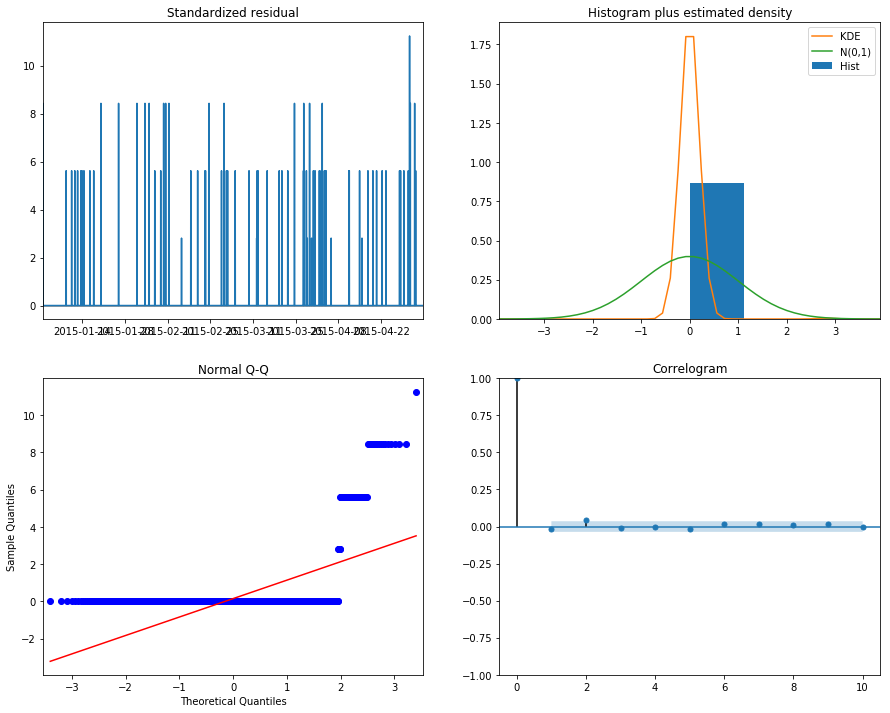

In [62]:
find_good_model(-2, 2, merged[:3000])

### Our Seasonal ARIMA model is not correlated with the Normal distribution. This means it can be improved. Let's widen the grid search to find a better model